This notebook assumes you are using sims_maf version >= 1.1, and have 'setup sims_maf' in your shell. 

This notebook shows how MAF can use the LSST camera geometry to decide if a region has been observed.

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
from lsst.sims.maf.plots import PlotHandler

In [2]:
import lsst.sims.maf
print(lsst.sims.maf.__version__)

2.8.0.sims


In [3]:
# Set the database and query
database = 'baseline2018a.db'
opsdb = db.OpsimDatabase(database)
ra_dec_constraints = (15, -15)

mjdcol = 'observationStartMJD'
degrees = True
fieldIdCol = 'fieldId'

sqlWhere = 'filter = "r" and night < 400 and fieldRA < %f and fieldDec > %f and fieldDec < 0' % (ra_dec_constraints)
outDir = 'Camera'
resultsDb = db.ResultsDb(outDir=outDir)

In [4]:
nside=512
metric = metrics.CountMetric(mjdcol)
slicer = slicers.HealpixSlicer(nside=nside, latLonDeg=degrees)
slicer2 = slicers.HealpixSlicer(nside=nside, useCamera=True, radius=1.9, latLonDeg=degrees)
summaryMetrics = [metrics.SumMetric()]

Healpix slicer using NSIDE=512, approximate resolution 6.870973 arcminutes
Healpix slicer using NSIDE=512, approximate resolution 6.870973 arcminutes


In [5]:
bundle1 = metricBundles.MetricBundle(metric,slicer,sqlWhere, summaryMetrics=summaryMetrics)
bundle2 = metricBundles.MetricBundle(metric,slicer2,sqlWhere, summaryMetrics=summaryMetrics)
bg = metricBundles.MetricBundleGroup({'NoCamera':bundle1, 'WithCamera':bundle2},opsdb, outDir=outDir, resultsDb=resultsDb)
bg.runAll()

Querying database SummaryAllProps with constraint filter = "r" and night < 400 and fieldRA < 15.000000 and fieldDec > -15.000000 and fieldDec < 0 for columns ['fieldDec', 'observationStartMJD', 'rotSkyPos', 'fieldRA']
Found 379 visits
Running:  ['NoCamera']
Completed metric generation.
Running:  ['WithCamera']


/home/docmaf/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/sims_coordUtils/2.8.0.sims/python/lsst/sims/coordUtils/CameraUtils.py:382: MultipleChipWarning: An object has landed on multiple chips.  You asked for this not to happen.
We will return only one of the chip names.  If you want both, try re-running with the kwarg allow_multiple_chips=True.
Offending chip names were ['R:0,4 S:2,0,A', 'R:0,4 S:2,0,B']
Offending pupil coordinate point was -0.019792645214 0.020511528636

  category=MultipleChipWarning)


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


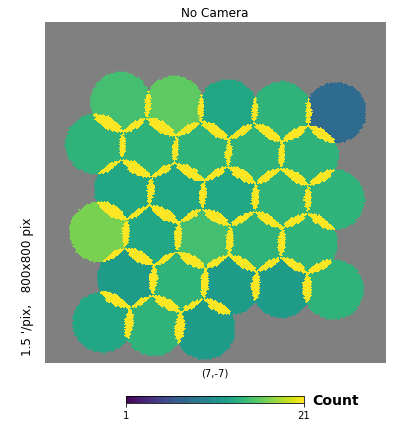

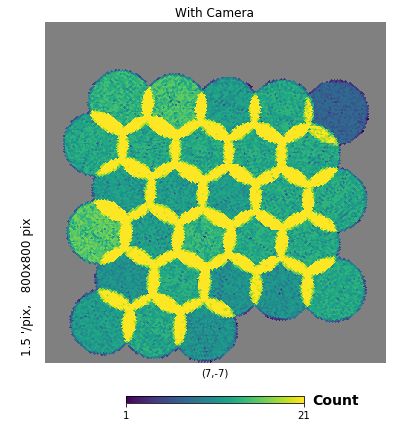

In [6]:
import healpy as hp
hp.gnomview(bundle1.metricValues, xsize=800,ysize=800, rot=(7,-7,0), title='No Camera', unit='Count', min=1,max=21)
hp.gnomview(bundle2.metricValues, xsize=800,ysize=800, rot=(7,-7,0),title='With Camera', unit='Count', min=1,max=21)

In [7]:
# Print the number of pixel observations in the 2 cases. Note that running without the camera is about 3-4% optimistic.
print (bundle1.summaryValues)
print (bundle2.summaryValues)

{'Sum': 277990.0}
{'Sum': 283560.0}


Now to try it again with dithering turned on

In [8]:
stacker = stackers.DefaultDitherStacker(fieldIdCol=fieldIdCol, degrees=degrees)
slicer = slicers.HealpixSlicer(latCol='ditheredDec', lonCol='ditheredRA', nside=nside, latLonDeg=degrees)
slicer2 = slicers.HealpixSlicer(latCol='ditheredDec', lonCol='ditheredRA',nside=nside, useCamera=True, radius=1.9, latLonDeg=degrees)
bundle1 = metricBundles.MetricBundle(metric,slicer, sqlWhere, stackerList=[stacker], summaryMetrics=summaryMetrics)
bundle2 = metricBundles.MetricBundle(metric,slicer2,sqlWhere, stackerList=[stacker], summaryMetrics=summaryMetrics)
bg = metricBundles.MetricBundleGroup({'NoCamera':bundle1, 'WithCamera':bundle2},opsdb, outDir=outDir, resultsDb=resultsDb)
bg.runAll()

Healpix slicer using NSIDE=512, approximate resolution 6.870973 arcminutes
Healpix slicer using NSIDE=512, approximate resolution 6.870973 arcminutes
Querying database SummaryAllProps with constraint filter = "r" and night < 400 and fieldRA < 15.000000 and fieldDec > -15.000000 and fieldDec < 0 for columns ['observationStartMJD', 'fieldDec', 'fieldId', 'night', 'rotSkyPos', 'fieldRA']
Found 379 visits
Running:  ['NoCamera']
Completed metric generation.
Running:  ['WithCamera']


/home/docmaf/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/sims_maf/2.8.0.sims/python/lsst/sims/maf/stackers/baseStacker.py:120: UserWarning: Warning - column ditheredRA already present in simData, may be overwritten (depending on stacker).
  % (col))
/home/docmaf/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/sims_maf/2.8.0.sims/python/lsst/sims/maf/stackers/baseStacker.py:120: UserWarning: Warning - column ditheredDec already present in simData, may be overwritten (depending on stacker).
  % (col))
/home/docmaf/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/sims_coordUtils/2.8.0.sims/python/lsst/sims/coordUtils/CameraUtils.py:382: MultipleChipWarning: An object has landed on multiple chips.  You asked for this not to happen.
We will return only one of the chip names.  If you want both, try re-running with the kwarg allow_multiple_chips=True.
Offending chip names were ['R:4,0 S:0,2,A', 'R:4,0 S:0,2,B']
Offending pupil coordinate point was 0.018552691106 -0.020521203145

  category=Multi

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


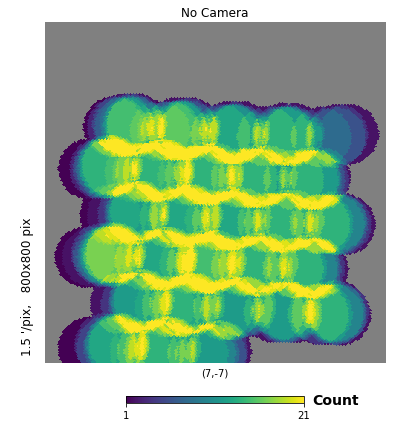

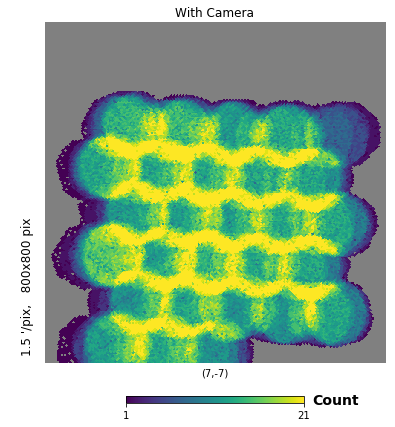

In [9]:
import healpy as hp
hp.gnomview(bundle1.metricValues, xsize=800,ysize=800, rot=(7,-7,0), title='No Camera', unit='Count', min=1,max=21)
hp.gnomview(bundle2.metricValues, xsize=800,ysize=800, rot=(7,-7,0),title='With Camera', unit='Count', min=1,max=21)

In [10]:
sqlWhere = '%s = 2266 and night < 500' % fieldIdCol
#nside = 2048 This uses a LOT of ram
nside = 1024
metric = metrics.CountMetric(mjdcol)
slicer = slicers.HealpixSlicer(nside=nside, useCamera=True, radius=1.9, latLonDeg=degrees)
bundle1 = metricBundles.MetricBundle(metric,slicer,sqlWhere)

bg = metricBundles.MetricBundleGroup({'HighResCamera':bundle1}, opsdb, outDir=outDir, resultsDb=resultsDb)
bg.runAll()

Healpix slicer using NSIDE=1024, approximate resolution 3.435486 arcminutes
Querying database SummaryAllProps with constraint fieldId = 2266 and night < 500 for columns ['fieldDec', 'observationStartMJD', 'rotSkyPos', 'fieldRA']
Found 136 visits
Running:  ['HighResCamera']


/home/docmaf/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/sims_coordUtils/2.8.0.sims/python/lsst/sims/coordUtils/CameraUtils.py:382: MultipleChipWarning: An object has landed on multiple chips.  You asked for this not to happen.
We will return only one of the chip names.  If you want both, try re-running with the kwarg allow_multiple_chips=True.
Offending chip names were ['R:4,0 S:0,2,A', 'R:4,0 S:0,2,B']
Offending pupil coordinate point was 0.021037444386 -0.020521995367

  category=MultipleChipWarning)
/home/docmaf/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/sims_coordUtils/2.8.0.sims/python/lsst/sims/coordUtils/CameraUtils.py:382: MultipleChipWarning: An object has landed on multiple chips.  You asked for this not to happen.
We will return only one of the chip names.  If you want both, try re-running with the kwarg allow_multiple_chips=True.
Offending chip names were ['R:4,0 S:0,2,A', 'R:4,0 S:0,2,B']
Offending pupil coordinate point was 0.021627857497 -0.020518745852

  category

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


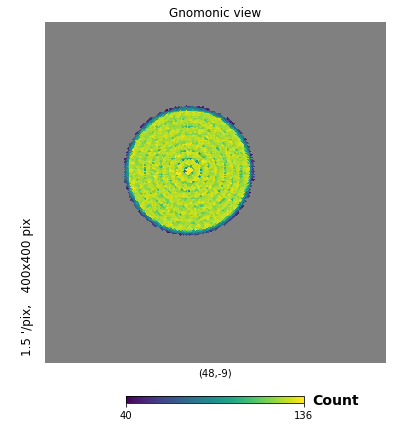

In [11]:
hp.gnomview(bundle1.metricValues, xsize=400,ysize=400, rot=(48,-9,0), unit='Count')